## Uso de Decision Trees para mostrar explicação de decisões via regras derivadas dos ramos da DT.

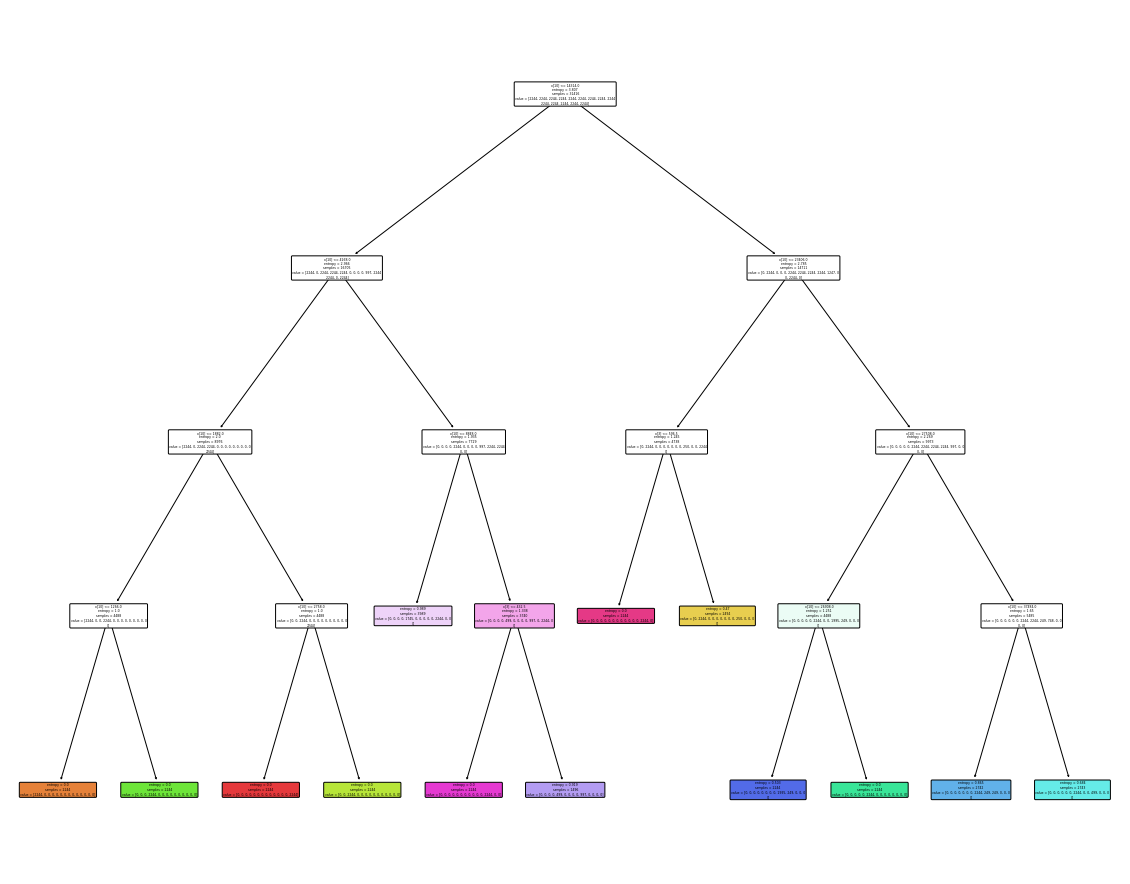

In [60]:
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt

file_name = '../measurements.csv'
df = pd.read_csv(file_name, header=0, delimiter=",", decimal=".")

#Outliers treatment
#NOTE: This will remove 14*3*2 entries (14 languages, 3 sorting algorithms and 2 cases - best and worst executions)

# Agrupar o DataFrame por colunas "Language" e "Program"
grouped = df.groupby(['Language', 'Program'])

# Inicializar um DataFrame vazio para armazenar o resultado
df_removed_entries = pd.DataFrame()

# Iterar sobre cada grupo
for group_name, group_df in grouped:
    # Identificar o índice da melhor (menor tempo) e pior (maior tempo) entrada no grupo
    best_entry_index = group_df['Time'].idxmin()
    worst_entry_index = group_df['Time'].idxmax()
    
    # Remover as linhas com base nos índices encontrados e adicionar ao DataFrame resultante
    group_df = group_df.drop([best_entry_index, worst_entry_index])
    
    # Concatenar o DataFrame do grupo com o DataFrame resultante
    df_removed_entries = pd.concat([df_removed_entries, group_df])

df = df_removed_entries.copy()

replace_map = {
    'Program': {
        'BubbleSort ': 0,
        'QuickSort ': 1,
        'SelectionSort ': 2
    }
}

replace_map2 = {'Language': {
                    'C ':0 ,
                    'Python Interpreted ': 1, 
                    'Python Compilled ': 2,
                    'Haskell ':3,
                    'Java ':4,
                    'C++ ':5,
                    'Prolog ':6,
                    'Ruby ':7,
                    'PHP ':8,
                    'Kotlin ':9,
                    'JavaScript ':10,
                    'C# ':11,
                    'Rust ':12,
                    'Go ':13
                    }}

y = df["Language"]
x = df.drop(columns=['Language'])
x.replace(replace_map, inplace=True)


clf = tree.DecisionTreeClassifier(random_state=2023, criterion='entropy', ccp_alpha=0.1)

plt.figure(figsize=(20, 16))
clf = clf.fit(x, y)
tree.plot_tree(clf, filled=True, rounded=True)
plt.show()


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [62]:
x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=2023)

In [63]:
clf = DecisionTreeClassifier(random_state=2023)
clf = clf.fit(x_train,y_train)

In [64]:
predictions_train = clf.predict(x_train)
predictions_test = clf.predict(x_test)

In [65]:
print("Classification report for training data")
print(classification_report(y_train, predictions_train))
print("\nClassification report for test data")
print(classification_report(y_test, predictions_test))

Classification report for training data
                     precision    recall  f1-score   support

                 C        1.00      1.00      1.00      1679
                C#        1.00      1.00      1.00      1667
               C++        1.00      1.00      1.00      1708
                Go        1.00      1.00      1.00      1699
           Haskell        1.00      1.00      1.00      1685
              Java        1.00      1.00      1.00      1692
        JavaScript        1.00      1.00      1.00      1642
            Kotlin        1.00      1.00      1.00      1706
               PHP        1.00      1.00      1.00      1655
            Prolog        1.00      1.00      1.00      1677
  Python Compilled        1.00      1.00      1.00      1710
Python Interpreted        1.00      1.00      1.00      1684
              Ruby        1.00      1.00      1.00      1648
              Rust        1.00      1.00      1.00      1710

           accuracy                        

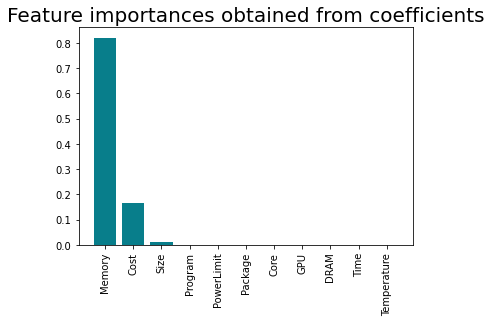

In [66]:
# Feature importance
clf.fit(x_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': clf.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [67]:
y = df["Language"]
x = df.drop(columns=['Language', 'Temperature', 'Time', 'DRAM', 'GPU', 'Core', 'Package', 'PowerLimit'])
x.replace(replace_map, inplace=True)

x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=2023)

x_test

,Program,Size,Cost,Memory
5453,1,1000,968,24616
18967,1,2500,992,924
25825,0,5000,632,27228
11684,2,2500,538,21960
17880,0,2500,538,21928
...,...,...,...,...
9286,2,1000,656,3468
11774,1,2500,968,26240
26519,2,5000,680,24716
5623,1,1000,775,27860


### Tuning

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_leaf': [0.05, 0.1, 0.2]}

grid_search = GridSearchCV(clf, param_grid, cv=10)

grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

predictions_train = grid_search.predict(x_train)
predictions_test = grid_search.predict(x_test)

print("Classification report for training data")
print(classification_report(y_train, predictions_train, zero_division=1))
print("\nClassification report for test data")
print(classification_report(y_test, predictions_test, zero_division=1))

Best parameters: {'max_depth': 8, 'min_samples_leaf': 0.05}
Best score: 0.9337493598161168
Classification report for training data
                     precision    recall  f1-score   support

                 C        1.00      1.00      1.00      1679
                C#        1.00      1.00      1.00      1667
               C++        1.00      1.00      1.00      1708
                Go        1.00      1.00      1.00      1699
           Haskell        0.95      0.66      0.78      1685
              Java        1.00      1.00      1.00      1692
        JavaScript        0.81      1.00      0.90      1642
            Kotlin        0.82      1.00      0.90      1706
               PHP        0.89      0.89      0.89      1655
            Prolog        0.70      0.52      0.59      1677
  Python Compilled        0.90      1.00      0.95      1710
Python Interpreted        1.00      1.00      1.00      1684
              Ruby        1.00      1.00      1.00      1648
              

### Previsão da linguagem dados alguns valores com o modelo treinado

In [76]:
# Assuming you have already defined the variables:
Program = "QuickSort "
Size = 1000
Cost = 500
Memory = 1000

# Create a dictionary with the input data
input_data = {
    'Program': [replace_map['Program'][Program]],
    'Size': [Size],
    'Cost': [Cost],
    'Memory': [Memory]
}

# Create a DataFrame from the input data
input_df = pd.DataFrame(input_data)

# Extract the feature columns (x) from the input DataFrame
x = input_df[["Program", "Size", "Cost", "Memory"]]

# Make predictions for the input data
prediction = grid_search.predict(x)

# Retrieve the inferred value of "Language"
inferred_language = prediction[0]

print("Inferred Language:", inferred_language)


Inferred Language: Go 
